In [1]:
from pathlib import Path


cfg_path = "configs/training/cityscapes/patch_size=4/base.yaml"
ckpt_path = "/work/gabrijel/track-generator-checkpoints/track-generator/cityscapes/latte(B, stride=1, patch_size=4, raw)/ckpt_epoch=1400.pth"

In [2]:
from omegaconf import OmegaConf

cfg = OmegaConf.load(cfg_path)
cfg

{'model': {'name': 'latte(B, stride=${model.nn.trajectory_stride}, patch_size=${model.nn.patch_size}, raw)', 'nn': {'image_size': 224, 'input_size': [56, 112], 'in_channels': 2, 'trajectory_length': 30, 'patch_size': 4, 'trajectory_stride': 1, 'frame_features_dim': 1024, 'num_horizontal_frame_tokens': 16, 'num_vertical_frame_tokens': 32, 'latent': False}, 'flow_matcher': 'target_conditional_flow_matcher'}, 'training': {'batch_size': 8, 'num_workers': 4, 'lr': 6e-05, 'seed': 42, 'use_amp': True, 'use_wandb': True, 'compile': True, 'precomputed_latents': False, 'epochs': 8192, 'num_steps_per_epoch': 186, 'log_every_steps': 32, 'checkpoint_every_epochs': 20, 'sample_every_steps': 186, 'num_trajectories_per_reference_frame': 6272, 'samples_path': '/scratch/shared/beegfs/gabrijel/experiments/track-generator/${dataset.name}/${model.name}/${preprocessing.starting_frame}/samples/train', 'checkpoints_path': '/scratch/shared/beegfs/gabrijel/experiments/track-generator/${dataset.name}/${model.nam

In [3]:
import torch

ckpt = torch.load(ckpt_path, map_location="cpu")

/tmp/ipykernel_1655353/2208486775.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


In [4]:
device = torch.device("cuda:3")

In [5]:
from nn_latte_rectangular import Latte


model = Latte(
    depth=12,
    hidden_size=384,
    patch_size=cfg.model.nn.patch_size,
    learn_sigma=False,
    num_heads=6,
    in_channels=cfg.model.nn.in_channels,
    num_frames=cfg.model.nn.get("trajectory_length", 24),
    frame_features_dim=cfg.model.nn.get("frame_features_dim", 384),
    input_size=cfg.model.nn.input_size,
    text_embed_dim=cfg.model.nn.get("text_embed_dim", None),
    num_horizontal_frame_tokens=cfg.model.nn.num_horizontal_frame_tokens,
    num_vertical_frame_tokens=cfg.model.nn.num_vertical_frame_tokens,
    latent=cfg.model.nn.get("latent", True)
).to(device)

/users/gabrijel/miniconda3/envs/track-generator/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/athenahomes/gabrijel/miniconda3/envs/track-generator/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [6]:
model.load_state_dict(ckpt["ema_state_dict"])
model = model.to(device)

In [7]:
from core import get_dataloaders
from dataset_split import DatasetSplit
from seed import seed_everything
from utils.cityscapes import (filter_valid_trajectories, map_to_tuple, map_to_batch)
from pathlib import Path
from glob import glob
import webdataset as wds

seed_worker_fn = seed_everything(42)

val_path = str(
    Path("./datasets/cityscapes") /
    DatasetSplit.VALIDATION /
    "*.tar"
)
val_urls = list(glob(val_path))
transform = map_to_tuple()
batch_size = 4

valset = wds.DataPipeline(
    wds.SimpleShardList(
        urls=[str(x) for x in val_urls]
    ),
    wds.split_by_worker,
    wds.tarfile_to_samples(),
    wds.decode(),
    wds.map(transform),
    wds.select(filter_valid_trajectories),  # type: ignore
    wds.batched(batch_size, partial=False),
    wds.map(map_to_batch)
)

In [8]:
val_iterator = iter(valset)
val_batch = next(val_iterator)

In [9]:
frames, tracks, frame_features, *_ = val_batch

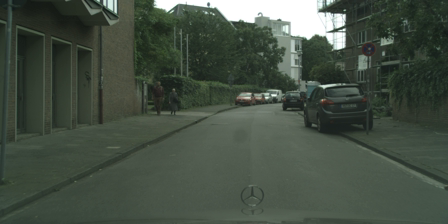

In [10]:
from PIL import Image

Image.fromarray(frames[0, 0].numpy())

In [11]:
from train_raw_cityscapes import sample_latte_raw

sampled_tracks = sample_latte_raw(
    model,
    frame_features[:, 1:, :],
    device,
    1,
    steps=10,
    method="euler"
)

sampling method=euler, steps=10, atol=1e-05, rtol=1e-05 ...


In [12]:
sampled_tracks.shape

torch.Size([4, 30, 2, 56, 112])

In [13]:
from einops import rearrange

from preprocessing import denormalize_points


sampled_tracks = rearrange(
    sampled_tracks,
    "b t c h w -> b t h w c"
)
sampled_tracks = denormalize_points(
    sampled_tracks,
    448,
    224
)

In [14]:
from cotracker_utils import Visualizer


visualizer = Visualizer(
    "./demos/cityscapes/base",
    linewidth=1,
    fps=30,
)

In [15]:
from einops import rearrange
from PIL import Image


for batch_idx in range(frames.shape[0]):
    Image.fromarray(frames[batch_idx, 0].numpy()).save(
        f"./demos/cityscapes/base/init_cond_{batch_idx}.jpg"
    )
    visualizer.visualize(
        video=rearrange(
            torch.zeros_like(frames[[batch_idx], ...]),
            "b t h w c -> b t c h w"
        ),
        tracks=rearrange(
            sampled_tracks[[batch_idx], ...],
            "b t h w c -> b t (h w) c"
        ),
        filename=f"pred_{batch_idx}"
    )
    visualizer.visualize(
        video=rearrange(
            frames[[batch_idx], ...],
            "b t h w c -> b t c h w"
        ),
        tracks=rearrange(
            tracks[[batch_idx], ...],
            "b t h w c -> b t (h w) c"
        ),
        filename=f"gt_{batch_idx}"
    )